In [10]:
import sys, os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from PIL import Image
from tqdm import tqdm
from annoy import AnnoyIndex


import torch
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_repo = '/home/baba/Bureau/ProjetPoster/'
data_path = os.path.join(main_repo, 'MovieGenre', 'content', 'sorted_movie_posters_paligema')
registers = os.listdir(data_path)

dev_repo = os.path.join(os.getcwd(), "dev")
sys.path.append(dev_repo)

from loader import *

In [2]:
#get labels
train_labels, test_labels, train_paths, test_paths = get_labels(registers, data_path)

#get loaders
train_loader, test_loader = generate_loaders(registers, data_path)

In [3]:
#loading model weights
resnet = models.resnet18()

num_classes = len(registers)
resnet.fc = torch.nn.Linear(in_features=512, out_features=num_classes)

resnet.load_state_dict(torch.load(main_repo + 'model.pth'))
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
#we remove the last layer used for classification
model = torch.nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, 
                            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
                            resnet.avgpool, torch.nn.Flatten()).cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 453.5, -0.5)

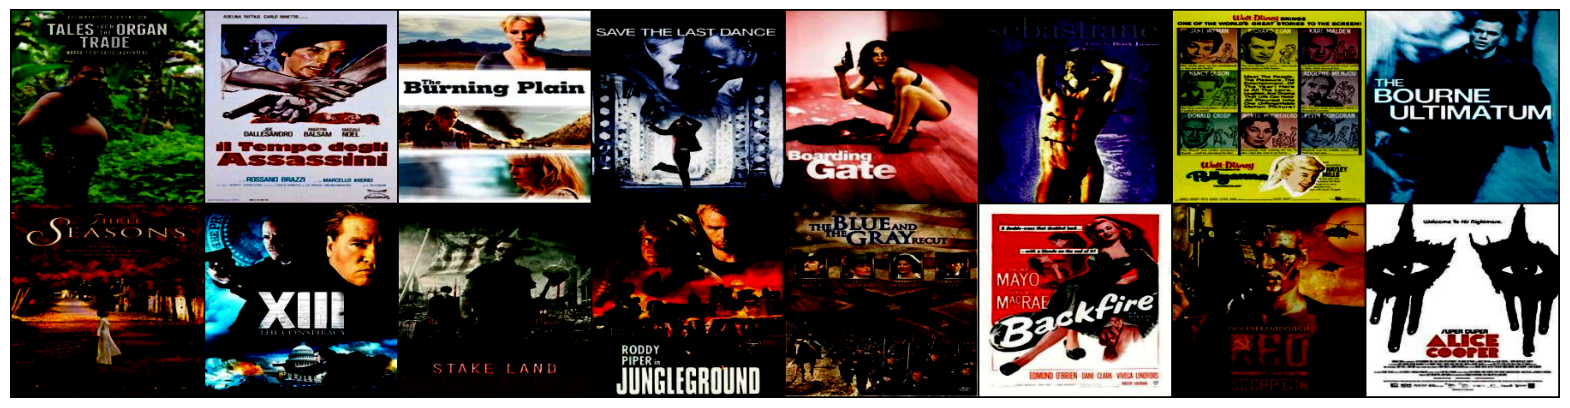

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, paths, labels = next(iter(train_loader))
img_grid = make_grid(x[:16])
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

## Annoy

In [6]:
features_list = []
paths_list = []

for x, paths, labels in tqdm(train_loader):
    with torch.no_grad():
        embeddings = model(x.cuda())
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

features = np.vstack(features_list)
features.shape

100%|██████████| 68/68 [00:17<00:00,  3.98it/s]


(4297, 512)

In [7]:
dim = 512
annoy_index = AnnoyIndex(dim, 'angular')

In [8]:
for i, embedding in enumerate(features_list):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

True

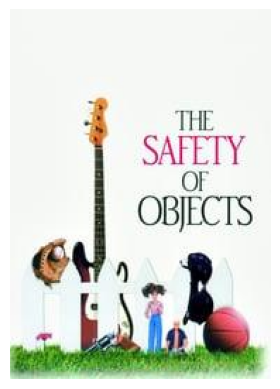

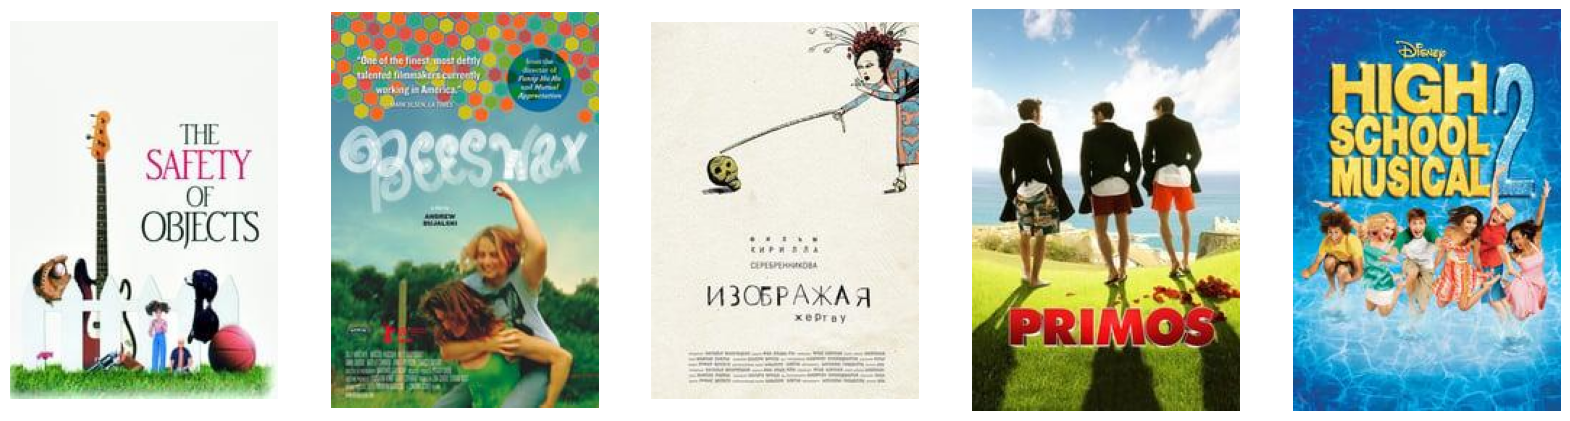

In [ ]:
def search(query_vector, k=5):
    indices = annoy_index.get_nns_by_vector(query_vector, k)
    paths = df['path'].iloc[indices]
    return paths

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
  fig = plt.figure(figsize=(20,15))
  for i, path in enumerate(paths_list):
    plt.subplot(1, len(paths_list), i+1)
    plot_image(path)

index = 20
plot_image(df.path[index])
query_vector = df.features[index]
result = search(query_vector)
plot_images(result)